In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/Hugging Face

Mounted at /content/gdrive
/content/gdrive/My Drive/Hugging Face


In [ ]:
import os

# Change this path to your target folder in Drive
dataset_dir = '/content/gdrive/MyDrive/Hugging Face/datasets/MinneApple'

os.makedirs(dataset_dir, exist_ok=True)

# Download the dataset tarball (replace with actual URL)
!wget -O minneapple.tar.gz https://conservancy.umn.edu/bitstreams/3ef26f04-6467-469b-9857-f443ffa1bb61/download

# Extract
!tar -tf minneapple.tar.gz | head -3

# ✅ Extract directly into the datasets folder (not nested again)
!tar -xzf minneapple.tar.gz -C "$dataset_dir"

print("MinneApple dataset downloaded and extracted to", dataset_dir)

--2025-07-08 10:56:01--  https://conservancy.umn.edu/bitstreams/3ef26f04-6467-469b-9857-f443ffa1bb61/download
Resolving conservancy.umn.edu (conservancy.umn.edu)... 134.84.72.217
Connecting to conservancy.umn.edu (conservancy.umn.edu)|134.84.72.217|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://conservancy.umn.edu/server/api/core/bitstreams/3ef26f04-6467-469b-9857-f443ffa1bb61/content [following]
--2025-07-08 10:56:02--  https://conservancy.umn.edu/server/api/core/bitstreams/3ef26f04-6467-469b-9857-f443ffa1bb61/content
Reusing existing connection to conservancy.umn.edu:443.
HTTP request sent, awaiting response... 200 200
Length: unspecified [application/gzip]
Saving to: ‘minneapple.tar.gz’

minneapple.tar.gz       [              <=>   ]   1.70G  30.3MB/s    in 60s     

2025-07-08 10:57:02 (29.0 MB/s) - ‘minneapple.tar.gz’ saved [1825397590]

detection/test/images/dataset2_back_630.png
detection/train/masks/20150919_174151_image11.png
detection/t

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/Hugging Face/datasets/MinneApple"
!ls "/content/gdrive/MyDrive/Hugging Face/datasets/MinneApple"

best_retinanet_model.pth  detection


In [2]:
import os
import json

def count_images(image_dir, exts={".jpg", ".jpeg", ".png", ".bmp", ".webp"}):
    image_count = 0
    for filename in os.listdir(image_dir):
        if os.path.splitext(filename.lower())[1] in exts:
            image_count += 1
    print(f"Total images: {image_count}")

count_images("datasets/MinneApple/detection/train_split/images")
count_images("datasets/MinneApple/detection/train_split/masks")
count_images("datasets/MinneApple/detection/val_split/images")
count_images("datasets/MinneApple/detection/val_split/masks")
count_images("datasets/MinneApple/detection/test/images")

Total images: 536
Total images: 536
Total images: 134
Total images: 134
Total images: 331


In [ ]:
import os
import shutil
import random
from tqdm import tqdm

# === CONFIG ===
ROOT_DIR = "/content/gdrive/MyDrive/Hugging Face/datasets/MinneApple/detection"
IMAGE_DIR = os.path.join(ROOT_DIR, "train/images")
MASK_DIR = os.path.join(ROOT_DIR, "train/masks")
SPLIT_DIR = ROOT_DIR  # train_split/ and val_split/ will go here

SPLIT_RATIO = 0.8
SEED = 42

# === Step 1: Collect image filenames ===
all_images = [f for f in os.listdir(IMAGE_DIR) if f.endswith((".png", ".jpg", ".jpeg"))]
all_images.sort()
random.seed(SEED)
random.shuffle(all_images)

split_idx = int(len(all_images) * SPLIT_RATIO)
train_files = all_images[:split_idx]
val_files = all_images[split_idx:]

print(f"Train: {len(train_files)} images, Val: {len(val_files)} images")

# === Step 2: Prepare folders ===
for split in ["train_split", "val_split"]:
    os.makedirs(os.path.join(SPLIT_DIR, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(SPLIT_DIR, split, "masks"), exist_ok=True)

# === Step 3: Move images and masks ===
def move_image_and_masks(file_list, split_name):
    for img_file in tqdm(file_list, desc=f"Moving {split_name}"):
        base = os.path.splitext(img_file)[0]
        img_path = os.path.join(IMAGE_DIR, img_file)
        mask_path = os.path.join(MASK_DIR, base + ".png")

        shutil.move(img_path, os.path.join(SPLIT_DIR, split_name, "images", img_file))
        shutil.move(mask_path, os.path.join(SPLIT_DIR, split_name, "masks", base + ".png"))

move_image_and_masks(train_files, "train_split")
move_image_and_masks(val_files, "val_split")

Train: 0 images, Val: 0 images


Moving train_split: 0it [00:00, ?it/s]
Moving val_split: 0it [00:00, ?it/s]


In [ ]:
import os
import json
import cv2
import numpy as np
from tqdm import tqdm

SPLIT_DIR = "/content/gdrive/MyDrive/Hugging Face/datasets/MinneApple/detection"
CATEGORY_NAME = "apple"

def masks_to_coco_from_grayscale_instances(split_name, save_path):
    image_folder = os.path.join(SPLIT_DIR, split_name, "images")
    mask_folder = os.path.join(SPLIT_DIR, split_name, "masks")

    coco = {
        "images": [],
        "annotations": [],
        "categories": [{"id": 1, "name": CATEGORY_NAME, "supercategory": "fruit"}]
    }

    ann_id = 1
    image_files = sorted(os.listdir(image_folder))

    for img_id, img_file in enumerate(tqdm(image_files, desc=f"Converting {split_name} to COCO")):
        img_path = os.path.join(image_folder, img_file)
        height, width = cv2.imread(img_path).shape[:2]

        coco["images"].append({
            "id": img_id,
            "file_name": img_file,
            "width": width,
            "height": height
        })

        base = os.path.splitext(img_file)[0]
        mask_path = os.path.join(mask_folder, base + ".png")
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is None or mask.max() == 0:
            continue

        instance_ids = np.unique(mask)
        instance_ids = instance_ids[instance_ids != 0]  # ignore background

        for inst_id in instance_ids:
            binary_mask = (mask == inst_id).astype(np.uint8)
            contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if not contours:
                continue

            for cnt in contours:
                area = float(cv2.contourArea(cnt))
                if area < 10:  # skip very small areas
                    continue

                segmentation = cnt.flatten().tolist()
                if len(segmentation) < 6:  # need at least 3 points
                    continue

                x, y, w, h = cv2.boundingRect(cnt)

                coco["annotations"].append({
                    "id": ann_id,
                    "image_id": img_id,
                    "category_id": 1,
                    "segmentation": [segmentation],
                    "bbox": [x, y, w, h],
                    "area": area,
                    "iscrowd": 0
                })
                ann_id += 1

    with open(save_path, "w") as f:
        json.dump(coco, f, indent=2)

# Run on both splits
masks_to_coco_from_grayscale_instances("train_split", os.path.join(SPLIT_DIR, "instances_seg_train.json"))
masks_to_coco_from_grayscale_instances("val_split", os.path.join(SPLIT_DIR, "instances_seg_val.json"))

Converting val_split to COCO: 100%|██████████| 134/134 [03:33<00:00,  1.59s/it]


In [ ]:
# Check train annotations
with open("datasets/MinneApple/detection/instances_seg_train.json") as f:
    train_data = json.load(f)
    print(f"Train images: {len(train_data['images'])}")
    print(f"Train annotations: {len(train_data['annotations'])}")
    print(f"Categories: {train_data['categories']}")

# Check validation
with open("datasets/MinneApple/detection/instances_seg_val.json") as f:
    valid_data = json.load(f)
    print(f"\nValid images: {len(valid_data['images'])}")
    print(f"Valid annotations: {len(valid_data['annotations'])}")
    print(f"Categories: {valid_data['categories']}")

Train images: 536
Train annotations: 22595
Categories: [{'id': 1, 'name': 'apple', 'supercategory': 'fruit'}]

Valid images: 134
Valid annotations: 5582
Categories: [{'id': 1, 'name': 'apple', 'supercategory': 'fruit'}]


Image: 20150921_132038_image1196.png
  BBoxes from JSON: 8
  Unique instances in grayscale mask: 8
Image: 20150919_174151_image381.png
  BBoxes from JSON: 85
  Unique instances in grayscale mask: 85
Image: 20150921_131453_image1056.png
  BBoxes from JSON: 56
  Unique instances in grayscale mask: 56
Image: 20150921_131453_image626.png
  BBoxes from JSON: 16
  Unique instances in grayscale mask: 16


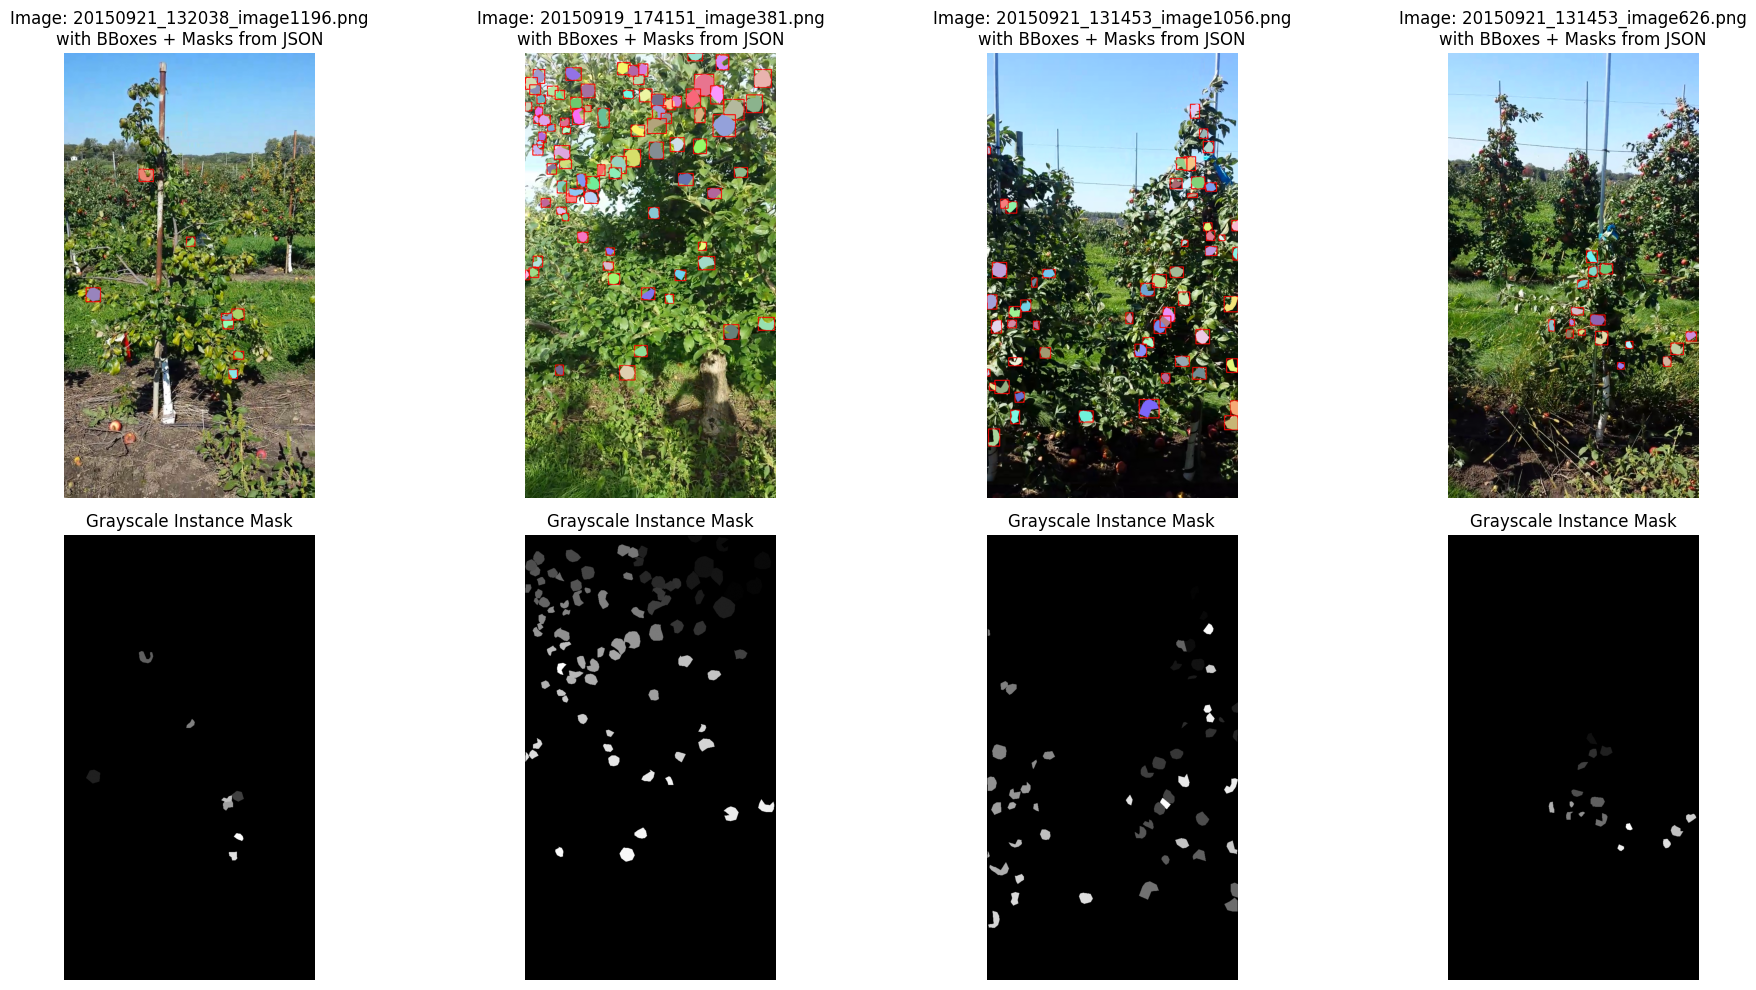

In [ ]:
import os
import random
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np

ROOT_DIR = "/content/gdrive/MyDrive/Hugging Face/datasets/MinneApple/detection"
TRAIN_SPLIT = os.path.join(ROOT_DIR, "train_split")
IMAGE_DIR = os.path.join(TRAIN_SPLIT, "images")
MASK_DIR = os.path.join(TRAIN_SPLIT, "masks")
JSON_PATH = os.path.join(ROOT_DIR, "instances_seg_train.json")

# Load COCO annotations
with open(JSON_PATH) as f:
    coco = json.load(f)

# Build dicts
image_id_to_annotations = {}
for ann in coco['annotations']:
    image_id_to_annotations.setdefault(ann['image_id'], []).append(ann)

image_id_to_name = {img['id']: img['file_name'] for img in coco['images']}

# Randomly select 4 image_ids
random.seed(40)
sample_image_ids = random.sample(list(image_id_to_name.keys()), 4)

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i, img_id in enumerate(sample_image_ids):
    img_name = image_id_to_name[img_id]
    img_path = os.path.join(IMAGE_DIR, img_name)
    mask_path = os.path.join(MASK_DIR, os.path.splitext(img_name)[0] + ".png")

    # Load image and grayscale mask
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    gray_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    annotations = image_id_to_annotations.get(img_id, [])
    bbox_count = len(annotations)
    unique_instances = len(np.unique(gray_mask)) - (1 if 0 in np.unique(gray_mask) else 0)

    print(f"Image: {img_name}")
    print(f"  BBoxes from JSON: {bbox_count}")
    print(f"  Unique instances in grayscale mask: {unique_instances}")

    # Draw bounding boxes and segmentations from JSON
    img_drawn = img.copy()
    for ann in annotations:
        # Draw bbox
        x, y, w, h = map(int, ann['bbox'])
        cv2.rectangle(img_drawn, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Draw polygon segmentation
        for seg in ann.get("segmentation", []):
            points = np.array(seg, dtype=np.int32).reshape((-1, 1, 2))
            color = [random.randint(100, 255) for _ in range(3)]
            cv2.fillPoly(img_drawn, [points], color=color)

    # Plot image with bbox + colored masks from JSON
    axs[0, i].imshow(img_drawn)
    axs[0, i].axis('off')
    axs[0, i].set_title(f"Image: {img_name}\nwith BBoxes + Masks from JSON")

    # Plot grayscale instance mask (original dataset)
    axs[1, i].imshow(gray_mask, cmap='gray')
    axs[1, i].axis('off')
    axs[1, i].set_title("Grayscale Instance Mask")

plt.tight_layout()
plt.show()

In [ ]:
!pip install -U 'git+https://github.com/facebookresearch/detectron2.git'

In [4]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [5]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=".*torch.cuda.amp.autocast.*")

In [6]:
from detectron2.data.datasets import register_coco_instances

DATASET_ROOT = "/content/gdrive/MyDrive/Hugging Face/datasets/MinneApple/detection"

register_coco_instances(
    "minneapple_train",
    {},
    f"{DATASET_ROOT}/instances_seg_train.json",
    f"{DATASET_ROOT}/train_split/images"
)

register_coco_instances(
    "minneapple_val",
    {},
    f"{DATASET_ROOT}/instances_seg_val.json",
    f"{DATASET_ROOT}/val_split/images"
)

In [7]:
from detectron2.data import MetadataCatalog, DatasetCatalog

print(DatasetCatalog.get("minneapple_train")[:2])
print(MetadataCatalog.get("minneapple_train"))

[07/17 06:06:25 d2.data.datasets.coco]: Loading /content/gdrive/MyDrive/Hugging Face/datasets/MinneApple/detection/instances_seg_train.json takes 2.49 seconds.
[07/17 06:06:25 d2.data.datasets.coco]: Loaded 536 images in COCO format from /content/gdrive/MyDrive/Hugging Face/datasets/MinneApple/detection/instances_seg_train.json
[{'file_name': '/content/gdrive/MyDrive/Hugging Face/datasets/MinneApple/detection/train_split/images/20150919_174151_image1.png', 'height': 1280, 'width': 720, 'image_id': 0, 'annotations': [{'iscrowd': 0, 'bbox': [137, 144, 24, 26], 'category_id': 0, 'segmentation': [[149, 144, 148, 145, 146, 145, 145, 146, 142, 146, 141, 147, 140, 147, 140, 148, 139, 149, 139, 152, 138, 153, 138, 156, 137, 157, 137, 160, 138, 161, 138, 162, 139, 163, 139, 165, 140, 166, 140, 167, 141, 168, 141, 169, 147, 169, 148, 168, 156, 168, 156, 167, 157, 166, 157, 165, 158, 164, 158, 163, 159, 162, 159, 161, 160, 160, 160, 159, 159, 158, 159, 157, 157, 155, 157, 154, 155, 152, 155, 151,

In [8]:
!git clone https://github.com/youngwanLEE/centermask2.git
%cd centermask2

fatal: destination path 'centermask2' already exists and is not an empty directory.
/content/gdrive/MyDrive/Hugging Face/centermask2


In [9]:
from centermask.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file("configs/centermask/centermask_V_39_eSE_FPN_ms_3x.yaml")

WARNING [07/17 06:06:58 d2.config.compat]: Config 'configs/centermask/centermask_V_39_eSE_FPN_ms_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [10]:
import os

cfg.MODEL.WEIGHTS = "/content/gdrive/MyDrive/Hugging Face/datasets/MinneApple/best_centermask2_model.pth"
cfg.MODEL.RESUME = False  # important: False means just load weights, don't look for previous logs

cfg.DATASETS.TRAIN = ("minneapple_train",)
cfg.DATASETS.TEST = ("minneapple_val",)

cfg.DATALOADER.NUM_WORKERS = 6  # 4 or more if you're not in Colab
cfg.INPUT.MIN_SIZE_TRAIN = (1024, 1152, 1280)
cfg.INPUT.MAX_SIZE_TRAIN = 2048

cfg.INPUT.MIN_SIZE_TEST = 1280
cfg.INPUT.MAX_SIZE_TEST = 2048

cfg.TEST.DETECTIONS_PER_IMAGE = 200
# 🔥 This one actually controls max detections for FCOS/CenterMask
cfg.MODEL.FCOS.POST_NMS_TOPK_TEST = 200

cfg.SOLVER.IMS_PER_BATCH = 6  # use 4 if memory limited
num_images = 536
epochs = 18
iters_per_epoch = num_images // cfg.SOLVER.IMS_PER_BATCH
cfg.SOLVER.MAX_ITER = iters_per_epoch * epochs
# Dynamic LR step schedule (50% and 80% of total iters)
cfg.SOLVER.BASE_LR = 0.00025

cfg.SOLVER.STEPS = (
    int(cfg.SOLVER.MAX_ITER * 0.5),
    int(cfg.SOLVER.MAX_ITER * 0.8)
)
# Evaluate every 5 epochs
cfg.TEST.EVAL_PERIOD = iters_per_epoch * 3 # 3 epoch
cfg.SOLVER.GAMMA = 0.1
warmup_iters = min(200, int(iters_per_epoch * 2))
cfg.SOLVER.WARMUP_ITERS = warmup_iters

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only "apple"

cfg.SOLVER.AMP.ENABLED = True  # Enable automatic mixed precision for speedup

cfg.SOLVER.CHECKPOINT_PERIOD = 200

cfg.OUTPUT_DIR = "/content/.cache/centermask_output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [11]:
import os
import torch
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import hooks
from detectron2.structures import Instances

class BestCheckpointerHook(hooks.EvalHook):
    def __init__(self, eval_period, model, cfg, save_path):
        self._model = model
        self._cfg = cfg
        self._best_metric = 30.024 # -1
        self._save_path = save_path  # ✅ Custom path for saving
        super().__init__(eval_period, self._do_eval)

    def _do_eval(self):
        evaluator = COCOEvaluator(self._cfg.DATASETS.TEST[0], self._cfg, True, output_dir=self._cfg.OUTPUT_DIR)
        val_loader = build_detection_test_loader(self._cfg, self._cfg.DATASETS.TEST[0])

        # Directly use self._model without wrapping or modifying outputs
        results = inference_on_dataset(self._model, val_loader, evaluator)

        # segm_ap = results["segm"]["AP"]
        # if segm_ap > self._best_metric:
        #     print(f"\n✅ New best model: segm AP improved from {self._best_metric:.2f} to {segm_ap:.2f}")
        #     self._best_metric = segm_ap
        #     os.makedirs(os.path.dirname(self._save_path), exist_ok=True)
        #     torch.save(self._model.state_dict(), self._save_path)
        #     print(f"📁 Best model saved to: {self._save_path}")
        # else:
        #     print(f"\nℹ️ segm AP = {segm_ap:.2f} (best = {self._best_metric:.2f})")

        bbox_ap = results["bbox"]["AP"]
        if bbox_ap > self._best_metric:
            print(f"\n✅ New best model: bbox AP improved from {self._best_metric:.2f} to {bbox_ap:.2f}")
            self._best_metric = bbox_ap
            os.makedirs(os.path.dirname(self._save_path), exist_ok=True)
            torch.save(self._model.state_dict(), self._save_path)
            print(f"📁 Best model saved to: {self._save_path}")
        else:
            print(f"\nℹ️ bbox AP = {bbox_ap:.2f} (best = {self._best_metric:.2f})")

        return results

class CenterMaskTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_dir=output_folder)

    def build_hooks(self):
        hooks_list = super().build_hooks()
        hooks_list.insert(
            -1,
            BestCheckpointerHook(
                self.cfg.TEST.EVAL_PERIOD,
                self.model,
                self.cfg,
                save_path=CUSTOM_BEST_MODEL_PATH  # ✅ actual Drive path, already defined outside
            )
        )
        return hooks_list

In [12]:
# Patch COCOEvaluator to avoid missing fields crash:
from pycocotools.coco import COCO
import copy
import json
import time

def patched_loadRes(self, resFile):
    tic = time.time()
    self.dataset.setdefault("info", {})
    self.dataset.setdefault("licenses", [])
    if isinstance(resFile, str):
        with open(resFile, 'r') as f:
            anns = json.load(f)
    elif isinstance(resFile, list):
        anns = resFile
    else:
        raise TypeError('resFile must be a file path or list of dicts')

    res = COCO()
    res.dataset['info'] = copy.deepcopy(self.dataset['info'])
    res.dataset['licenses'] = copy.deepcopy(self.dataset['licenses'])
    res.dataset['images'] = copy.deepcopy(self.dataset['images'])

    assert isinstance(anns, list), 'Annotations must be a list'
    anns_img_ids = [ann['image_id'] for ann in anns]
    assert set(anns_img_ids).issubset(set(self.getImgIds()))

    for idx, ann in enumerate(anns):
        ann.setdefault('id', idx + 1)
        if 'area' not in ann:
            if 'bbox' in ann:
                _, _, w, h = ann['bbox']
                ann['area'] = w * h
            else:
                ann['area'] = 0

    res.dataset['annotations'] = anns
    res.createIndex()
    print(f'Annotations loaded in {time.time() - tic:.2f}s')
    return res

COCO.loadRes = patched_loadRes

In [13]:
CUSTOM_BEST_MODEL_PATH = "/content/gdrive/MyDrive/Hugging Face/datasets/MinneApple/best_centermask2_model.pth"

In [14]:
trainer = CenterMaskTrainer(cfg)

[07/17 06:07:13 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): VoVNet(
      (stem): Sequential(
        (stem_1/conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (stem_1/norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        (stem_1/relu): R

/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:474: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = GradScaler()


In [15]:
torch.cuda.empty_cache()

In [ ]:
trainer.resume_or_load(resume=False)
trainer.train()

[07/15 02:50:10 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from  ...
[07/15 02:50:10 d2.engine.train_loop]: Starting training from iteration 0
[07/15 02:50:43 d2.utils.events]:  eta: 1:49:12  iter: 19  total_loss: 3.463  loss_mask: 0.6932  loss_maskiou: 0.01089  loss_fcos_cls: 1.117  loss_fcos_loc: 0.9575  loss_fcos_ctr: 0.6865    time: 1.6549  last_time: 1.6280  data_time: 0.0297  last_data_time: 0.0132   lr: 2.3976e-05  max_mem: 12082M
[07/15 02:51:15 d2.utils.events]:  eta: 1:47:48  iter: 39  total_loss: 2.979  loss_mask: 0.6931  loss_maskiou: 0.1264  loss_fcos_cls: 0.5542  loss_fcos_loc: 0.9073  loss_fcos_ctr: 0.6892    time: 1.6281  last_time: 1.5366  data_time: 0.0143  last_data_time: 0.0143   lr: 4.8951e-05  max_mem: 12082M
[07/15 02:51:47 d2.utils.events]:  eta: 1:46:47  iter: 59  total_loss: 2.676  loss_mask: 0.693  loss_maskiou: 0.0379  loss_fcos_cls: 0.4602  loss_fcos_loc: 0.8039  loss_fcos_ctr: 0.683    time: 1.6218  last_time: 1.5814  data_time: 0

In [ ]:
trainer.resume_or_load(resume=False)
trainer.train()

[07/15 17:09:35 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/gdrive/MyDrive/Hugging Face/datasets/MinneApple/best_centermask2_model.pth ...
[07/15 17:09:42 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[07/15 17:10:21 d2.utils.events]:  eta: 0:21:10  iter: 19  total_loss: 1.719  loss_mask: 0.5857  loss_maskiou: 0.00567  loss_fcos_cls: 0.1819  loss_fcos_loc: 0.2949  loss_fcos_ctr: 0.6576    time: 1.6527  last_time: 1.6274  data_time: 0.1354  last_data_time: 0.0231   lr: 2.3976e-05  max_mem: 11271M
[07/15 17:10:58 d2.utils.events]:  eta: 0:20:32  iter: 39  total_loss: 1.727  loss_mask: 0.5967  loss_maskiou: 0.005824  loss_fcos_cls: 0.1711  loss_fcos_loc: 0.2946  loss_fcos_ctr: 0.6568    time: 1.6352  last_time: 1.5608  data_time: 0.0308  last_data_time: 0.0189   lr: 4.8951e-05  max_mem: 11283M
[07/15 17:11:31 d2.utils.events]:  eta: 0:20:12  iter: 59  total_loss: 1.738  loss_mask: 0.5873  loss_maskiou: 0.005626  loss_fcos_cls: 0.1786  loss_fcos_loc: 0.3051  loss_fcos_ctr: 0.655    time: 1.6482  last_time: 1.5850  data_time: 0.0281  last_data_time: 0.0185   lr: 7.3926e-05  max_mem: 11470M
[07/15 17:12:05 d2.utils.events]:  eta: 0:19:45  iter: 79  total_loss: 1.723  loss_mask: 0.5855  lo

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[07/15 17:21:27 d2.evaluation.evaluator]: Inference done 11/134. Dataloading: 0.0040 s/iter. Inference: 0.3094 s/iter. Eval: 0.2355 s/iter. Total: 0.5488 s/iter. ETA=0:01:07
[07/15 17:21:32 d2.evaluation.evaluator]: Inference done 23/134. Dataloading: 0.0036 s/iter. Inference: 0.3002 s/iter. Eval: 0.1595 s/iter. Total: 0.4635 s/iter. ETA=0:00:51
[07/15 17:21:37 d2.evaluation.evaluator]: Inference done 35/134. Dataloading: 0.0034 s/iter. Inference: 0.2985 s/iter. Eval: 0.1462 s/iter. Total: 0.4482 s/iter. ETA=0:00:44
[07/15 17:21:43 d2.evaluation.evaluator]: Inference done 46/134. Dataloading: 0.0045 s/iter. Inference: 0.2998 s/iter. Eval: 0.1535 s/iter. Total: 0.4579 s/iter. ETA=0:00:40
[07/15 17:21:48 d2.evaluation.evaluator]: Inference done 58/134. Dataloading: 0.0041 s/iter. Inference: 0.2998 s/iter. Eval: 0.1451 s/iter. Total: 0.4491 s/iter. ETA=0:00:34
[07/15 17:21:55 d2.evaluation.evaluator]: Inference done 64/134. Dataloading: 0.0806 s/iter. Inference: 0.3005 s/iter. Eval: 0.141

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[07/15 17:23:27 d2.evaluation.evaluator]: Inference done 11/134. Dataloading: 0.0019 s/iter. Inference: 0.2984 s/iter. Eval: 0.0967 s/iter. Total: 0.3969 s/iter. ETA=0:00:48
[07/15 17:23:32 d2.evaluation.evaluator]: Inference done 24/134. Dataloading: 0.0026 s/iter. Inference: 0.2978 s/iter. Eval: 0.0974 s/iter. Total: 0.3980 s/iter. ETA=0:00:43
[07/15 17:23:37 d2.evaluation.evaluator]: Inference done 36/134. Dataloading: 0.0036 s/iter. Inference: 0.3000 s/iter. Eval: 0.1104 s/iter. Total: 0.4142 s/iter. ETA=0:00:40
[07/15 17:23:42 d2.evaluation.evaluator]: Inference done 49/134. Dataloading: 0.0034 s/iter. Inference: 0.2991 s/iter. Eval: 0.1083 s/iter. Total: 0.4108 s/iter. ETA=0:00:34
[07/15 17:23:48 d2.evaluation.evaluator]: Inference done 62/134. Dataloading: 0.0035 s/iter. Inference: 0.2982 s/iter. Eval: 0.1084 s/iter. Total: 0.4102 s/iter. ETA=0:00:29
[07/15 17:23:53 d2.evaluation.evaluator]: Inference done 74/134. Dataloading: 0.0038 s/iter. Inference: 0.2980 s/iter. Eval: 0.110

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[07/15 17:36:01 d2.evaluation.evaluator]: Inference done 11/134. Dataloading: 0.0020 s/iter. Inference: 0.2931 s/iter. Eval: 0.1000 s/iter. Total: 0.3950 s/iter. ETA=0:00:48
[07/15 17:36:06 d2.evaluation.evaluator]: Inference done 24/134. Dataloading: 0.0027 s/iter. Inference: 0.2937 s/iter. Eval: 0.1040 s/iter. Total: 0.4005 s/iter. ETA=0:00:44
[07/15 17:36:11 d2.evaluation.evaluator]: Inference done 36/134. Dataloading: 0.0044 s/iter. Inference: 0.2965 s/iter. Eval: 0.1127 s/iter. Total: 0.4139 s/iter. ETA=0:00:40
[07/15 17:36:16 d2.evaluation.evaluator]: Inference done 49/134. Dataloading: 0.0039 s/iter. Inference: 0.2962 s/iter. Eval: 0.1089 s/iter. Total: 0.4093 s/iter. ETA=0:00:34
[07/15 17:36:22 d2.evaluation.evaluator]: Inference done 61/134. Dataloading: 0.0038 s/iter. Inference: 0.2970 s/iter. Eval: 0.1135 s/iter. Total: 0.4145 s/iter. ETA=0:00:30
[07/15 17:36:27 d2.evaluation.evaluator]: Inference done 74/134. Dataloading: 0.0036 s/iter. Inference: 0.2971 s/iter. Eval: 0.113

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[07/15 17:36:58 d2.evaluation.evaluator]: Inference done 11/134. Dataloading: 0.0019 s/iter. Inference: 0.2935 s/iter. Eval: 0.1000 s/iter. Total: 0.3954 s/iter. ETA=0:00:48
[07/15 17:37:03 d2.evaluation.evaluator]: Inference done 23/134. Dataloading: 0.0034 s/iter. Inference: 0.2975 s/iter. Eval: 0.1237 s/iter. Total: 0.4247 s/iter. ETA=0:00:47
[07/15 17:37:09 d2.evaluation.evaluator]: Inference done 36/134. Dataloading: 0.0036 s/iter. Inference: 0.2967 s/iter. Eval: 0.1142 s/iter. Total: 0.4146 s/iter. ETA=0:00:40
[07/15 17:37:14 d2.evaluation.evaluator]: Inference done 49/134. Dataloading: 0.0033 s/iter. Inference: 0.2957 s/iter. Eval: 0.1120 s/iter. Total: 0.4112 s/iter. ETA=0:00:34
[07/15 17:37:19 d2.evaluation.evaluator]: Inference done 61/134. Dataloading: 0.0038 s/iter. Inference: 0.2967 s/iter. Eval: 0.1159 s/iter. Total: 0.4166 s/iter. ETA=0:00:30
[07/15 17:37:24 d2.evaluation.evaluator]: Inference done 74/134. Dataloading: 0.0038 s/iter. Inference: 0.2962 s/iter. Eval: 0.113

In [ ]:
trainer.resume_or_load(resume=False)
trainer.train()

[07/16 16:32:07 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/gdrive/MyDrive/Hugging Face/datasets/MinneApple/best_centermask2_model.pth ...
[07/16 16:32:07 d2.engine.train_loop]: Starting training from iteration 0
[07/16 16:32:44 d2.utils.events]:  eta: 0:43:39  iter: 19  total_loss: 1.68  loss_mask: 0.5695  loss_maskiou: 0.005435  loss_fcos_cls: 0.171  loss_fcos_loc: 0.2825  loss_fcos_ctr: 0.6557    time: 1.6578  last_time: 1.5870  data_time: 0.0800  last_data_time: 0.0163   lr: 2.6909e-05  max_mem: 16700M
[07/16 16:33:21 d2.utils.events]:  eta: 0:42:56  iter: 39  total_loss: 1.709  loss_mask: 0.5748  loss_maskiou: 0.005611  loss_fcos_cls: 0.1759  loss_fcos_loc: 0.2938  loss_fcos_ctr: 0.6545    time: 1.6572  last_time: 1.5684  data_time: 0.0188  last_data_time: 0.0197   lr: 5.4971e-05  max_mem: 16700M
[07/16 16:33:54 d2.utils.events]:  eta: 0:42:16  iter: 59  total_loss: 1.707  loss_mask: 0.5733  loss_maskiou: 0.005738  loss_fcos_cls: 0.1746  loss

In [ ]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2 import model_zoo
import os

# 🔧 Setup config
cfg = get_cfg()
cfg.merge_from_file("configs/centermask/centermask_V_39_eSE_FPN_ms_3x.yaml")
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = "/content/gdrive/MyDrive/Hugging Face/datasets/MinneApple/best_centermask2_model.pth"
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only "apple"
cfg.INPUT.MIN_SIZE_TEST = 1280  # ← same as training
cfg.INPUT.MAX_SIZE_TEST = 2048  # ← same as training
cfg.TEST.DETECTIONS_PER_IMAGE = 200
# 🔥 This one actually controls max detections for FCOS/CenterMask
cfg.MODEL.FCOS.POST_NMS_TOPK_TEST = 200
cfg.SOLVER.AMP.ENABLED = True
cfg.OUTPUT_DIR = "/content/.cache/centermask_output"

# 🧪 Run evaluation
evaluator = COCOEvaluator("minneapple_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "minneapple_val")
results = inference_on_dataset(DefaultPredictor(cfg).model, val_loader, evaluator)

print("\n📊 Evaluation Results on Saved Best Model:")
print(results)

WARNING [07/16 17:35:01 d2.config.compat]: Config 'configs/centermask/centermask_V_39_eSE_FPN_ms_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
WARNING [07/16 17:35:01 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[07/16 17:35:01 d2.data.datasets.coco]: Loaded 134 images in COCO format from /content/gdrive/MyDrive/Hugging Face/datasets/MinneApple/detection/instances_seg_val.json
[07/16 17:35:01 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(1280, 1280), max_size=2048, sample_style='choice')]
[07/16 17:35:01 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[07/16 17:35:01 d2.data.common]: Serializing 134 elements to byte tensors and concatenating them all ...
[07/16 17:35:01 d2.data.common]: Serialized dataset takes 1.51 MiB
[07/16 17:35:02 d2.check

In [32]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
import json
import numpy as np
import os

def iou(boxA, boxB):
    # Convert [x1,y1,x2,y2]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2]-boxA[0])*(boxA[3]-boxA[1])
    boxBArea = (boxB[2]-boxB[0])*(boxB[3]-boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou

def simple_prf1(gt_annotations, pred_annotations, iou_threshold=0.5, score_threshold=0.5):
    # Group GT and preds by image_id
    gt_by_img = {}
    for ann in gt_annotations:
        gt_by_img.setdefault(ann['image_id'], []).append(ann['bbox'])

    pred_by_img = {}
    for ann in pred_annotations:
        if ann.get('score', 1.0) >= score_threshold:
            pred_by_img.setdefault(ann['image_id'], []).append(ann['bbox'])

    TP = 0
    FP = 0
    FN = 0

    for img_id, gt_boxes in gt_by_img.items():
        preds = pred_by_img.get(img_id, [])
        gt_used = [False]*len(gt_boxes)

        preds_xyxy = [[x, y, x+w, y+h] for x,y,w,h in preds]
        gt_xyxy = [[x, y, x+w, y+h] for x,y,w,h in gt_boxes]

        for pred_box in preds_xyxy:
            matched = False
            for i, gt_box in enumerate(gt_xyxy):
                if not gt_used[i] and iou(pred_box, gt_box) >= iou_threshold:
                    TP += 1
                    gt_used[i] = True
                    matched = True
                    break
            if not matched:
                FP += 1

        FN += gt_used.count(False)

    precision = TP / (TP + FP + 1e-8) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN + 1e-8) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall + 1e-8) if (precision + recall) > 0 else 0

    print(f"📊 Precision: {precision:.4f}")
    print(f"📊 Recall:    {recall:.4f}")
    print(f"📊 F1 Score:  {f1:.4f}")

def evaluate_prf1_best(cfg, dataset_name, model_weights, iou_thresh=0.5, score_thresh=0.5):
    cfg.MODEL.WEIGHTS = model_weights
    predictor = DefaultPredictor(cfg)

    output_dir = cfg.OUTPUT_DIR
    evaluator = COCOEvaluator(dataset_name, cfg, False, output_dir=output_dir)
    val_loader = build_detection_test_loader(cfg, dataset_name)

    print("🔍 Running inference and saving predictions...")
    inference_on_dataset(predictor.model, val_loader, evaluator)

    annotation_file = "/content/gdrive/MyDrive/Hugging Face/datasets/MinneApple/detection/instances_seg_val.json"
    prediction_file = os.path.join(output_dir, "coco_instances_results.json")

    if not os.path.exists(prediction_file):
        raise FileNotFoundError(f"Prediction file not found at: {prediction_file}")

    with open(annotation_file) as f:
        gt_data = json.load(f)
    with open(prediction_file) as f:
        pred_data = json.load(f)

    simple_prf1(
        gt_data['annotations'],
        pred_data,
        iou_threshold=iou_thresh,
        score_threshold=score_thresh,
    )

# Example usage (adjust paths as needed)
cfg = get_cfg()
cfg.merge_from_file("configs/centermask/centermask_V_39_eSE_FPN_ms_3x.yaml")
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = "/content/gdrive/MyDrive/Hugging Face/datasets/MinneApple/best_centermask2_model.pth"
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only "apple"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.3
cfg.TEST.DETECTIONS_PER_IMAGE = 200
# 🔥 This one actually controls max detections for FCOS/CenterMask
cfg.MODEL.FCOS.POST_NMS_TOPK_TEST = 200
cfg.INPUT.MIN_SIZE_TEST = 1280  # ← same as training
cfg.INPUT.MAX_SIZE_TEST = 2048  # ← same as training
cfg.SOLVER.AMP.ENABLED = True
cfg.OUTPUT_DIR = "/content/.cache/centermask_output"

evaluate_prf1_best(cfg, "minneapple_val", cfg.MODEL.WEIGHTS)

WARNING [07/17 07:18:05 d2.config.compat]: Config 'configs/centermask/centermask_V_39_eSE_FPN_ms_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
[07/17 07:18:06 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/gdrive/MyDrive/Hugging Face/datasets/MinneApple/best_centermask2_model.pth ...
WARNING [07/17 07:18:06 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[07/17 07:18:06 d2.data.datasets.coco]: Loaded 134 images in COCO format from /content/gdrive/MyDrive/Hugging Face/datasets/MinneApple/detection/instances_seg_val.json
[07/17 07:18:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(1280, 1280), max_size=2048, sample_style='choice')]
[07/17 07:18:06 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[07/17 07:18:06 d2

In [ ]:
import random
import cv2
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer, ColorMode
import math
import torch

def run_gt_vs_result_comparison(num_images):
    cfg = get_cfg()
    cfg.merge_from_file("configs/centermask/centermask_V_39_eSE_FPN_ms_3x.yaml")
    cfg.DATALOADER.NUM_WORKERS = 4
    cfg.MODEL.DEVICE = "cuda"
    cfg.MODEL.WEIGHTS = "/content/gdrive/MyDrive/Hugging Face/datasets/MinneApple/best_centermask2_model.pth"
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only "apple"
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.3
    cfg.TEST.DETECTIONS_PER_IMAGE = 200
    # 🔥 This one actually controls max detections for FCOS/CenterMask
    cfg.MODEL.FCOS.POST_NMS_TOPK_TEST = 200
    cfg.INPUT.MIN_SIZE_TEST = 1280
    cfg.INPUT.MAX_SIZE_TEST = 2048
    cfg.SOLVER.AMP.ENABLED = True

    predictor = DefaultPredictor(cfg)

    metadata = MetadataCatalog.get("minneapple_val")
    dataset_dicts = DatasetCatalog.get("minneapple_val")
    sampled_dicts = random.sample(dataset_dicts, num_images)

    cols = 6  # GT|Pred pair
    rows = math.ceil(num_images / (cols // 2))

    plt.figure(figsize=(cols * 3, rows * 3))

    for idx, d in enumerate(sampled_dicts):
        img_path = d["file_name"]
        img = cv2.imread(img_path)
        img_rgb = img[:, :, ::-1].copy()

        # === Ground Truth Visualizer (includes masks)
        v_gt = Visualizer(img_rgb.copy(), metadata=metadata, scale=1.0, instance_mode=ColorMode.IMAGE)
        v_gt = v_gt.draw_dataset_dict(d)
        img_gt = v_gt.get_image()

        gt_boxes = [ann["bbox"] for ann in d["annotations"]] if "annotations" in d else []
        for b in gt_boxes:
            x1, y1, w, h = map(int, b)
            cv2.rectangle(img_gt, (x1, y1), (x1 + w, y1 + h), (255, 0, 0), 2)  # red

        # === Prediction Visualizer (masks)
        outputs = predictor(img)
        instances = outputs["instances"].to("cpu")

        # Filter top detections
        scores = instances.scores if instances.has("scores") else torch.tensor([])
        keep = scores > cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST
        if cfg.MODEL.FCOS.POST_NMS_TOPK_TEST > 0:
            topk = min(len(scores[keep]), cfg.MODEL.FCOS.POST_NMS_TOPK_TEST)
            keep_indices = scores[keep].argsort(descending=True)[:topk]
            instances = instances[keep.nonzero()[keep_indices].squeeze(1)]

        v_pred = Visualizer(img_rgb.copy(), metadata=metadata, scale=1.0, instance_mode=ColorMode.IMAGE)
        v_pred = v_pred.draw_instance_predictions(instances)
        img_pred = v_pred.get_image()

        if instances.has("pred_boxes"):
            for box in instances.pred_boxes.tensor.numpy():
                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(img_pred, (x1, y1), (x2, y2), (0, 255, 255), 2)  # cyan

        # === Plot
        plt.subplot(rows, cols, idx * 2 + 1)
        plt.imshow(img_gt)
        plt.axis("off")
        plt.title(f"GT count: {len(gt_boxes)}")

        plt.subplot(rows, cols, idx * 2 + 2)
        plt.imshow(img_pred)
        plt.axis("off")
        plt.title(f"Pred count: {len(instances)}")

    plt.tight_layout()
    plt.show()

WARNING [07/16 17:43:30 d2.config.compat]: Config 'configs/centermask/centermask_V_39_eSE_FPN_ms_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
[07/16 17:43:31 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/gdrive/MyDrive/Hugging Face/datasets/MinneApple/best_centermask2_model.pth ...
[07/16 17:43:31 d2.data.datasets.coco]: Loaded 134 images in COCO format from /content/gdrive/MyDrive/Hugging Face/datasets/MinneApple/detection/instances_seg_val.json


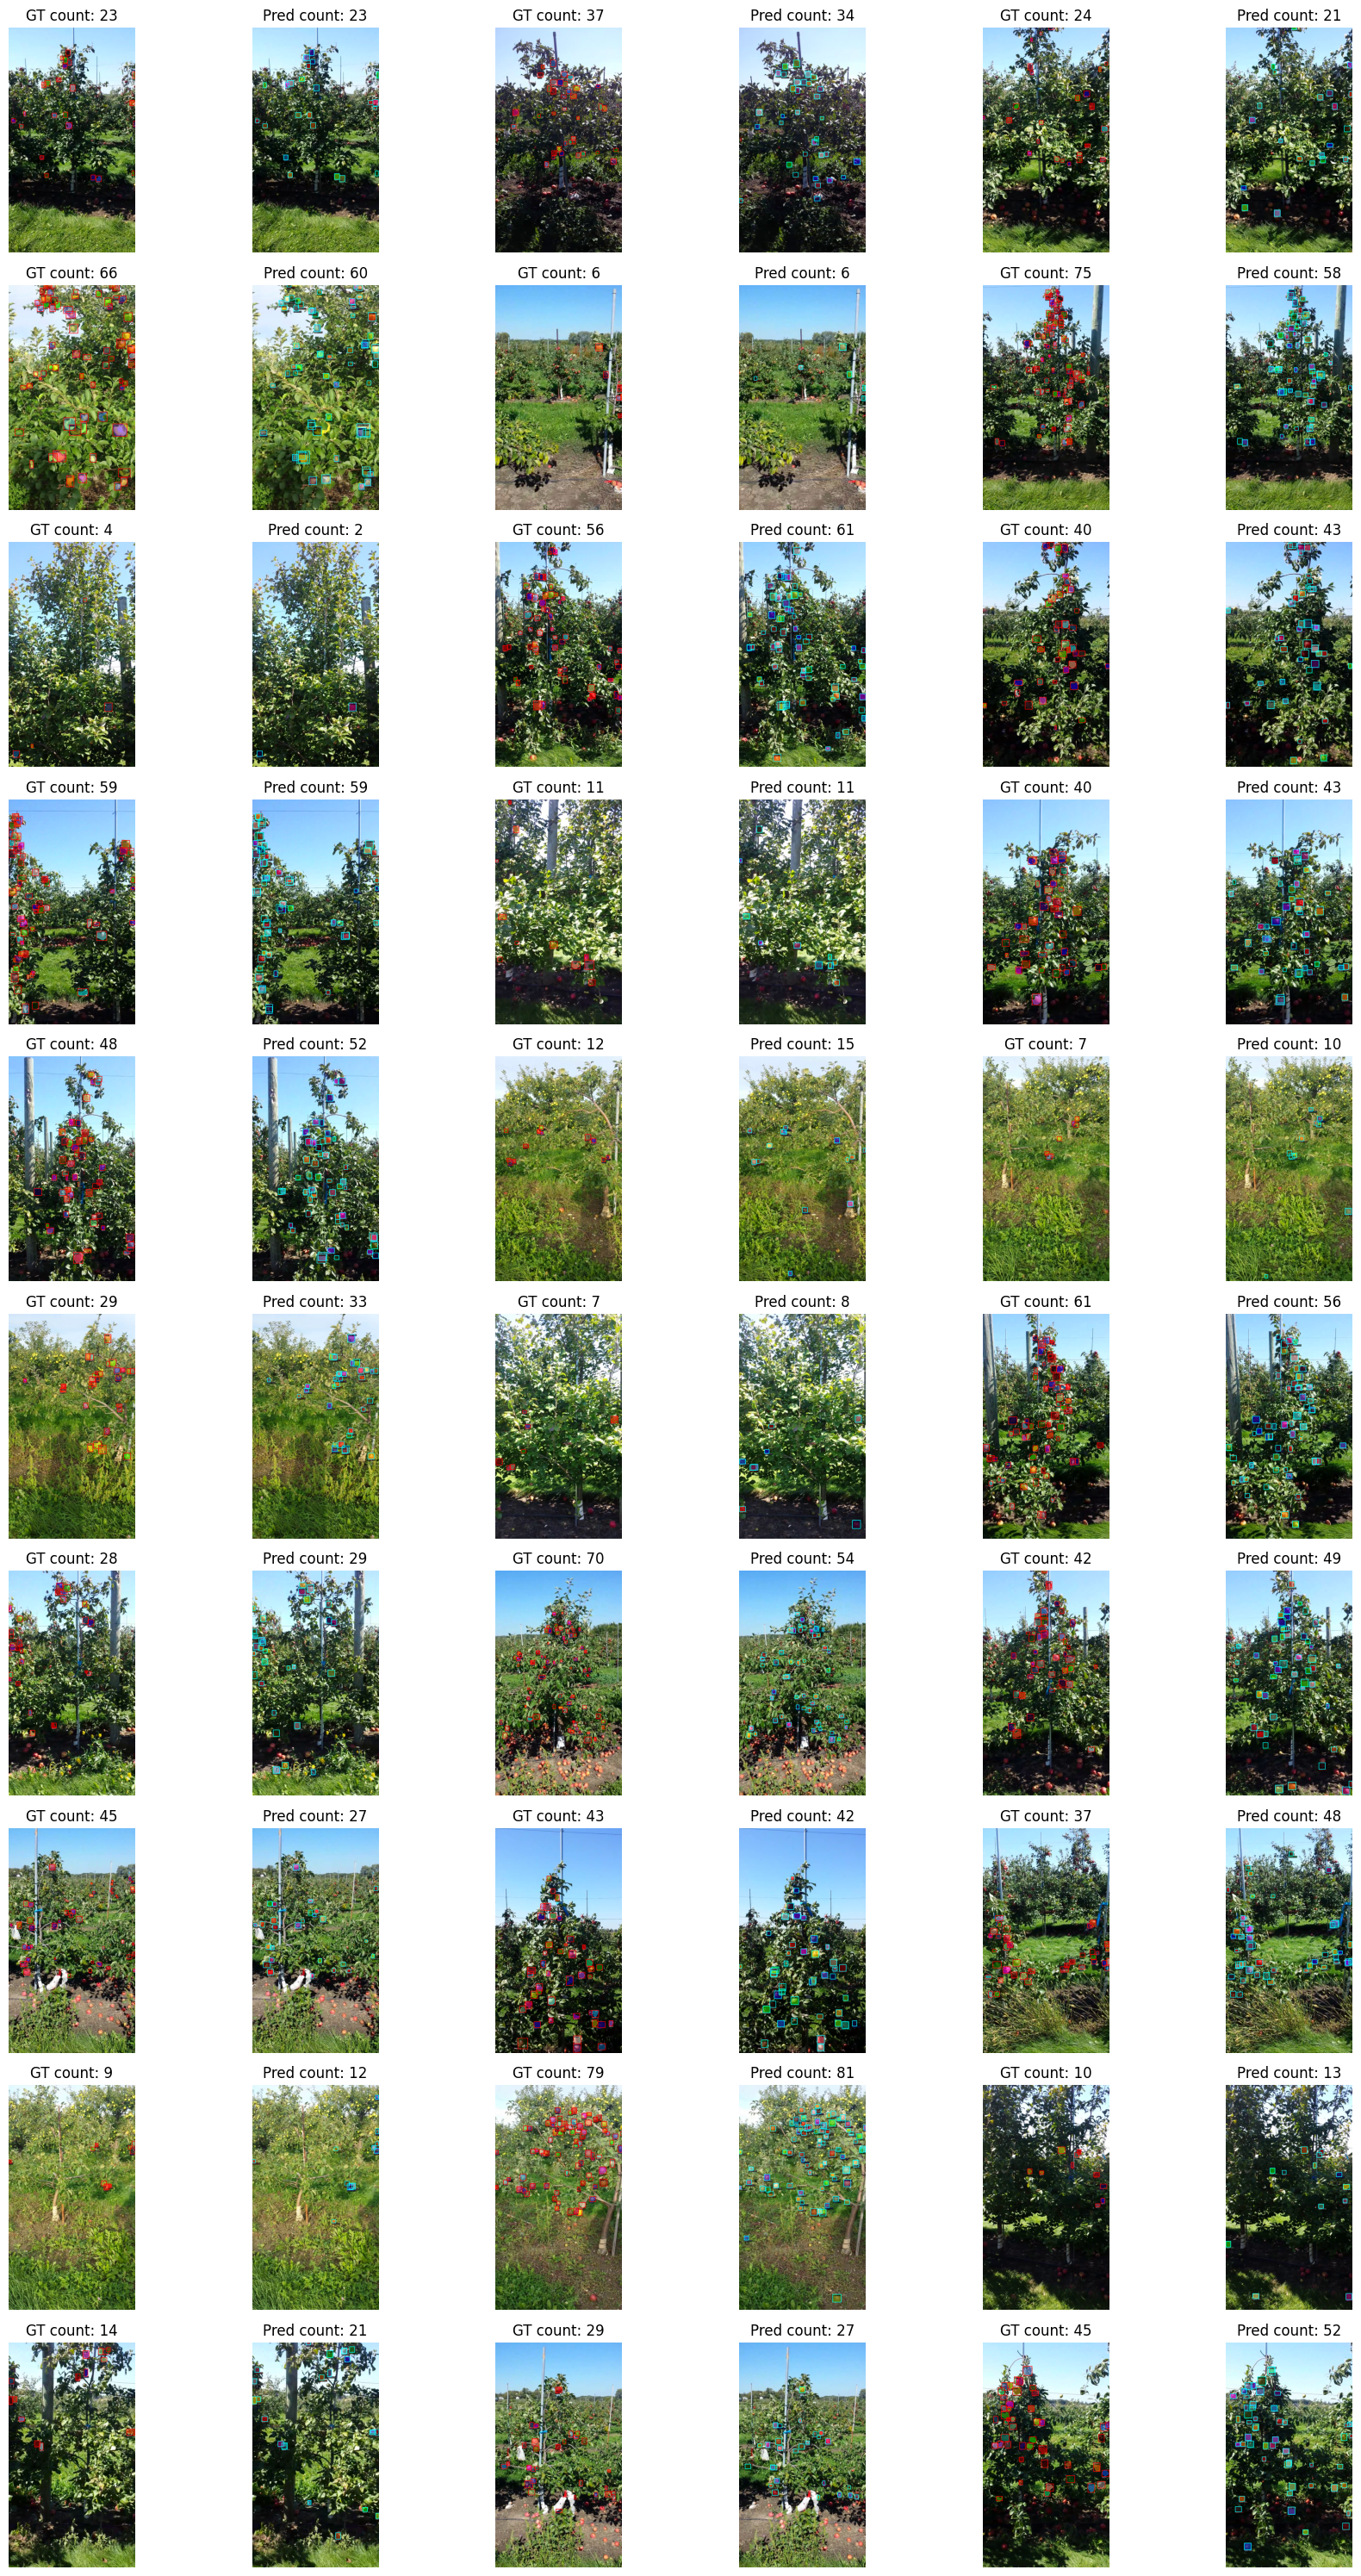

In [ ]:
run_gt_vs_result_comparison(30)